In [11]:
from __future__ import annotations

import jax.numpy as jnp
import liesel.model as lsl
import numpy as np
import scipy.stats
from jax import random
from liesel.model.nodes import no_model_setter
import tensorflow_probability.substrates.jax as tfp

#from .custom_types import Array, TFPDistribution
import liesel_ptm as ptm
import liesel_ptm.survival as sur

# Generate survival data (easy case)
key = random.key(0) # generate PRNG keys
shape = ptm.sample_shape(key, nshape=8).sample # set shape vector
#x = random.uniform(key) # generate uniformly distributed covariate (not used)
ln_y = ptm.PTMLocScaleDataGen(shape = shape,loc_fn= lambda x: x, ncov=1) # set DGP ()
ln_y_sample = ptm.PTMLocScaleDataGen.sample(key=key, self=ln_y, nobs= 100) # draw ln(y) (already generates x same time)
#y = jnp.exp(ln_y_sample["y"]) # compute duration times by exp(ln(y))
y = np.exp(ln_y_sample["y"])

x = ln_y_sample["x"]

# Create indicators of censored data
c = scipy.stats.bernoulli.rvs(p = 0.05, size = 100)
c0 = tfp.distributions.Bernoulli(probs=0.05).sample(100, seed= key) # draw samples via tfp

# draw censoring time
u = scipy.stats.uniform.rvs(loc = 0.001, scale = y - 0.0001, size = 100) # draw 100 samples of sencoring time
u0 = tfp.distributions.Uniform(low=0.00001, high= y).sample(100, seed=key)

y_hat = np.copy(y)
y_hat[c0 ==1] = u[c0==1] # set y_hat as y with censored data u when c = 1

# Build the model with Liesel
b0 = lsl.param(0.0, name = "b0")
x_ptm = lsl.obs(x, name="x_ptm")
b1 = lsl.param(0.0, name="b1")

def linear_model(x, b0, b1):# set the linear regression of x
    return b0 + x*b1

mu = lsl.Var(lsl.Calc(linear_model, x = x, b0 = b0, b1 = b1), name = "mu")
sigma_sq = lsl.param(10.0, name="sigma_sq")
sigma = lsl.Var(lsl.Calc(jnp.sqrt, sigma_sq), name="sigma")
y_dist = lsl.Dist(tfp.distributions.Normal, loc = mu, scale= sigma)
y_ptm = lsl.obs(jnp.log(y_hat), y_dist, name="y_sur")
sur_ptm = lsl.GraphBuilder().add(y_ptm)
sur_ptm_model = sur_ptm.build_model()

liesel.model.nodes - WARNING - Calc(name="_model_log_lik") was not updated during initialization, because the following exception occured: RuntimeError('Error while updating Calc(name="_model_log_lik").'). See debug log for the full traceback.
liesel.model.nodes - WARNING - Calc(name="_model_log_prob") was not updated during initialization, because the following exception occured: RuntimeError('Error while updating Calc(name="_model_log_prob").'). See debug log for the full traceback.


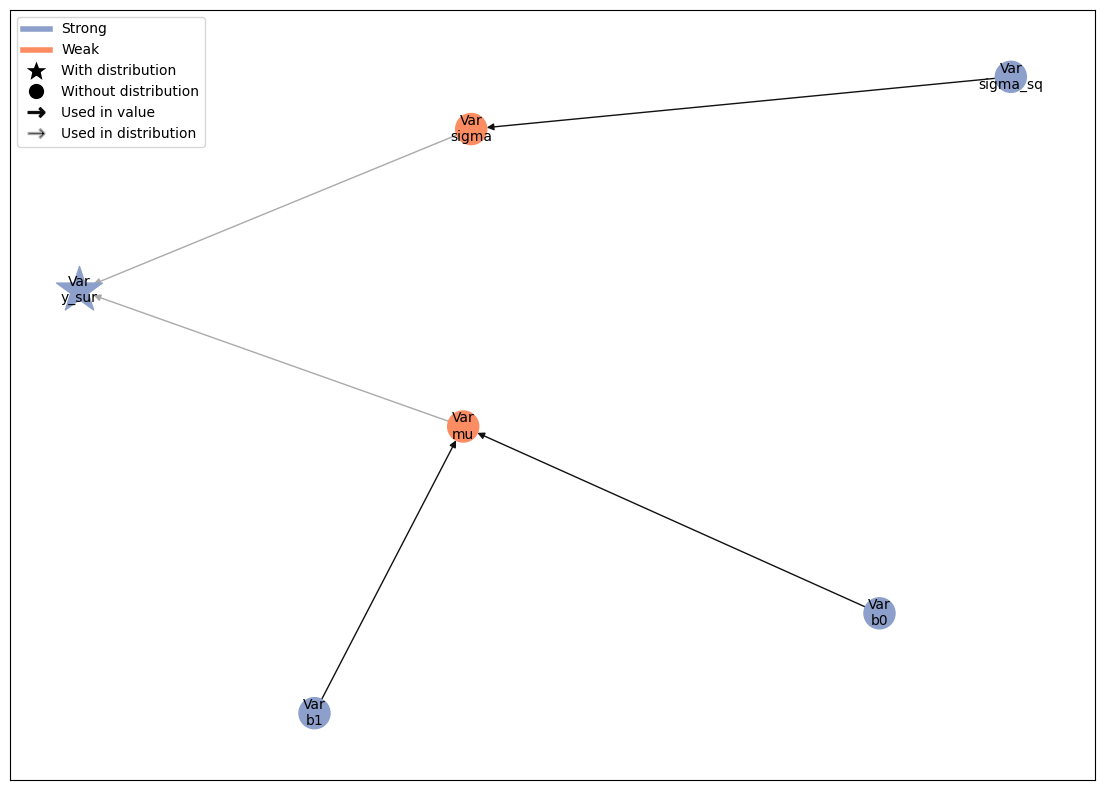

In [12]:
lsl.plot_vars(sur_ptm_model)
#model, linear regression, var relate to each other. blue: strong node -- new info in model. 
#arrow --- input to sigma (black --- sigma_sq calculating sigma) (gray --- not used to calculate the variable but the pdf, parameter of dist.)
# weak node --- not much info 
# star --- strong and with dist.
# plot helps to understand the complex model

In [13]:
print(sur_ptm_model.log_prob)
print(sur_ptm_model.log_lik)
print(sur_ptm_model.log_prior)

-217.0903
-217.0903
0
